In [55]:
import numpy as np
import json
import matplotlib.pyplot as plt

net_type = ["spinn","pfnn"][0]
E_init = 100000.0
nu_init = 0.2
iteration = 300000
time = [5, False][0]
nDIC =36
noise = 0
run_number = 0

run = f"{net_type}_E-{E_init}_nu-{nu_init}_nDIC-{nDIC}_noise-{noise}_{time if time else iteration}{'min' if time else 'iter'}{f"-{run_number}" if run_number else ''}"
save_folder = [r"../results_inverse/",r"/mnt/d/phd/SPIQ/loaded_plate/inverse/"][0]

run_folder = save_folder + run + "/"


with open(run_folder + "config.json") as f:
    run_config = json.load(f)

def read_data_file(filename):
    with open(filename, "r") as f:
        # Read the file and split each line
        steps = []
        values = []
        for line in f.readlines():
            step, value = line.strip().split(' ',1)
            steps.append(eval(step))
            values.append(eval(value))


    return steps, values

def moving_average(arr, window_size):
    window = np.ones(window_size)/window_size
    return np.apply_along_axis(lambda x: np.convolve(x, window, mode='valid'), 0, arr)

def moving_min(arr, window_size):
    new_arr = np.zeros((arr.shape[0] - window_size + 1, arr.shape[1]))
    for n_metric in range(arr.shape[1]):
        for i in range(new_arr.shape[0]):
            new_arr[i, n_metric] = np.min(arr[i:i+window_size, n_metric])
    return new_arr
    
loss_history = np.loadtxt(run_folder + "loss_history.dat")
loss_history_mean = moving_average(loss_history, 20)
loss_history_min = moving_min(loss_history, 20)
variables_history =  read_data_file(run_folder + "variables_history.dat")

residuals = loss_history[:, -1]
PDE_loss = np.mean(loss_history[:, 1:3], axis=1)
Mat_loss = np.mean(loss_history[:, 3:5], axis=1) 
DIC_loss = np.mean(loss_history[:, 5:7], axis=1)
steps_loaded = loss_history[:, 0]

E_init = run_config["E_init"]
nu_init = run_config["nu_init"]
E_actual = run_config["E_actual"]
nu_actual = run_config["nu_actual"]

lmbd_init = E_init * nu_init / ((1 + nu_init) * (1 - 2*nu_init))  # Lame's first parameter
mu_init = E_init / (2 * (1 + nu_init))  # Lame's second parameter
lmbd_actual = E_actual * nu_actual / ((1 + nu_actual) * (1 - 2*nu_actual))  # Lame's first parameter
mu_actual = E_actual / (2 * (1 + nu_actual))  # Lame's second parameter

E_actual = E_actual / 1e3 # GPa

# if run_config["lame_params"]:
# lmbd_history = np.array(variables_history[1])[:len(steps_loaded),0]*lmbd_init
# mu_history = np.array(variables_history[1])[:len(steps_loaded),1]*mu_init
# E_history = mu_history * (3*lmbd_history + 2*mu_history) / (lmbd_history + mu_history) / 1e3 # GPa
# nu_history = lmbd_history / (2*(lmbd_history +  mu_history))
# else:
params_iter_speed = run_config["params_iter_speed"]
E_history = np.array(variables_history[1])[:len(steps_loaded),0]/1e3#*E_init# GPa
nu_history = np.array(variables_history[1])[:len(steps_loaded),1]#*nu_init
lmbd_history = E_history * nu_history / ((1 + nu_history) * (1 - 2*nu_history)) 
mu_history = E_history / (2 * (1 + nu_history))

param_to_plot = "E" 
if param_to_plot == "lame":
    param1_history = lmbd_history
    param2_history = mu_history
    param1_init = lmbd_init
    param2_init = mu_init
    param1_actual = lmbd_actual
    param2_actual = mu_actual
    param1_name = r"$\lambda$"
    param2_name = r"$\mu$"

else:
    param1_history = E_history
    param2_history = nu_history
    param1_init = E_init
    param2_init = nu_init
    param1_actual = E_actual
    param2_actual = nu_actual
    param1_name = r"$E(GPa)$"
    param2_name = r"$\nu$"

metrics = [residuals, PDE_loss, Mat_loss, DIC_loss]
metrics_names = ["Rel. l2 error", "PDE Loss", "Material Loss", "DIC Loss"]

# fig, axs = plt.subplots(1, 1, figsize=(10, 5))

# axs.plot(loss_history[:, 0], loss_history[:, -1], loss_history_min[:, 0], loss_history_min[:, -1], loss_history_mean[:, 0], loss_history_mean[:, -1])
# axs.set_yscale('log')

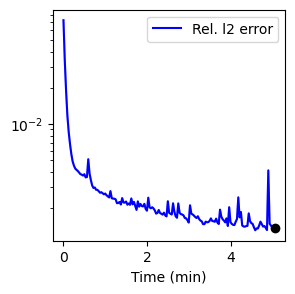

In [56]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation


step_type = ["iteration", "time"][1]
time_unit = ["s", "min"][1]
metrics_idx = [0]#, 1, 2, 3]

t_elapsed = run_config["elapsed"]
if step_type == "time":
    steps = np.array(steps_loaded) * t_elapsed/steps_loaded[-1]
    if time_unit == "min":
        steps = steps/60
else:
    steps = steps_loaded

def init_metrics(ax, metrics_idx=[0]):
    ax.set_yscale('log')
    lines = []
    scatters = []
    for idx in metrics_idx:
        ax.plot(steps, metrics[idx], alpha=0.2, color=['b', 'r', 'g', 'y'][idx])
        lines.append(ax.plot([], [], zorder=3, color=['b', 'r', 'g', 'y'][idx], label=metrics_names[idx])[0])
        scatters.append(ax.scatter([], [], c='k', zorder=4))


    # line_pinn, = ax.plot([], [], color='b', zorder=3)
    # ax.plot(steps, residuals, color='b', alpha=0.2)
    # scatter_pinn = ax.scatter([], [], c='k', zorder=4)
    ax.legend()
    # ax.set_ylabel("Mean residual")
    if step_type == "time":
        ax.set_xlabel(f"Time ({time_unit})")
    else:
        ax.set_xlabel("Iterations")
    return lines, scatters

def update_metrics(iterations, lines, scatters, metrics_idx=[0]):

    for line, scatter, metric_idx in zip(lines, scatters, metrics_idx):
        line.set_data(steps[:iterations], metrics[metric_idx][:iterations])
        scatter.set_offsets([steps[iterations], metrics[metric_idx][iterations]])

    return lines, scatters

fig, axs = plt.subplots(1, 1, figsize=(3, 3), dpi=100)
lines, scatters = init_metrics(axs,  metrics_idx=metrics_idx)
update_metrics(-1, lines, scatters, metrics_idx=metrics_idx)
plt.show()

# anim = animation.FuncAnimation(fig, update_losshistory, fargs=(line_pinn, line_spinn, scatter_pinn, scatter_spinn), frames=int(len(losshistory_pinn)/10), interval=100, repeat=False)
# HTML(anim.to_jshtml())

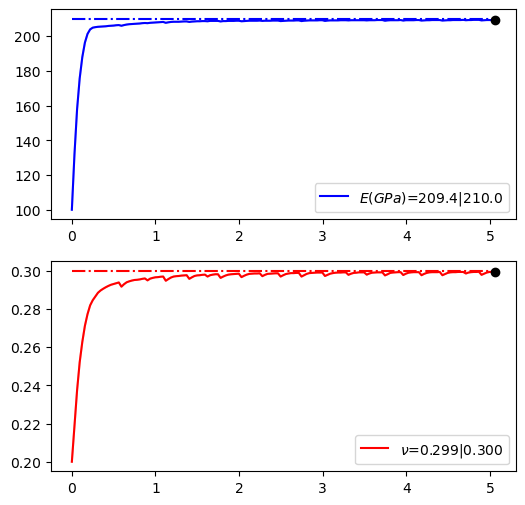

In [57]:


def init_variables(axs):
    # ax.set_yscale('log')
    axs[0].hlines(y=param1_actual,xmin=0, xmax=steps.max(), linestyles='-.', colors="b")#, label=r"Actual $\lambda=$"+f"{lambda_actual}")
    axs[1].hlines(y=param2_actual,xmin=0, xmax=steps.max(), linestyles='-.', colors="r")#, label=r"Actual $\mu=$"+f"{mu_actual}")
    line_E, = axs[0].plot([], [], color='b', zorder=3, label=param1_name+f"={param1_history[0]:.3f}|{param1_actual:.3f}")
    line_nu, = axs[1].plot([], [], color='r', zorder=3,label=param2_name+f"={param2_history[0]:.3f}|{param2_actual:.3f}")
    axs[0].plot(steps, param1_history, color='b', alpha=0.2)
    axs[1].plot(steps, param2_history, color='r', alpha=0.2)
    scatter_E = axs[0].scatter([], [], c='k', zorder=4)
    scatter_nu = axs[1].scatter([], [], c='k', zorder=4)

    axs[0].legend()
    axs[1].legend()
    # if step_type == "time":
    #     axs[1].set_xlabel(f"Time ({time_unit})")
    # else:
    #     axs[1].set_xlabel("Iterations")
    return line_E, line_nu, scatter_nu, scatter_E, axs

def update_variables(iterations, line_E, line_nu, scatter_nu, scatter_E,axs):

    line_E.set_data(steps[:iterations], param1_history[:iterations])
    line_E.set_label(param1_name+f"={param1_history[iterations]:.1f}|{param1_actual:.1f}")
    scatter_E.set_offsets([steps[iterations], param1_history[iterations]])
    line_nu.set_data(steps[:iterations], param2_history[:iterations])
    line_nu.set_label(param2_name+f"={param2_history[iterations]:.3f}|{param2_actual:.3f}")
    scatter_nu.set_offsets([steps[iterations], param2_history[iterations]])
    axs[0].legend()
    axs[1].legend()
    return line_E, line_nu, scatter_nu, scatter_E, axs

fig, axs = plt.subplots(2, 1, figsize=(6, 6), dpi=100)
line_E, line_nu, scatter_nu, scatter_E,axs = init_variables(axs)
update_variables(-1, line_E, line_nu, scatter_nu, scatter_E, axs)
plt.show()

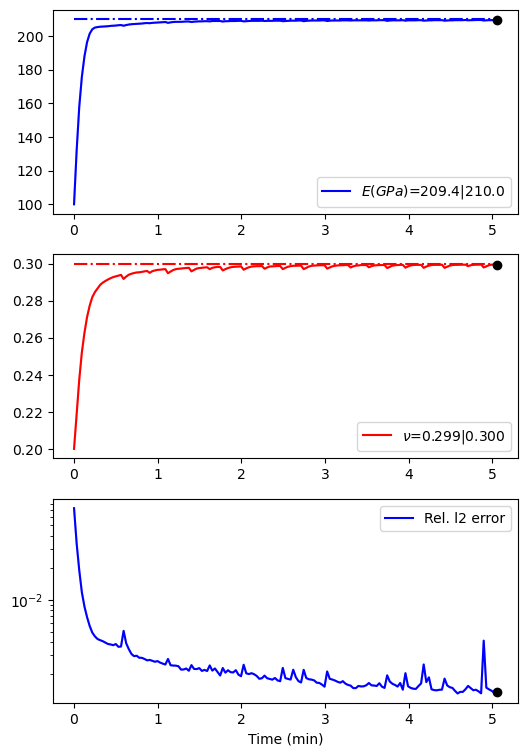

In [58]:
fig, axs = plt.subplots(3, 1, figsize=(6, 9), dpi=100)
lines, scatters = init_metrics(axs[-1],  metrics_idx=metrics_idx)
update_metrics(-1, lines, scatters, metrics_idx=metrics_idx)
line_E, line_nu, scatter_nu, scatter_E,ax_params = init_variables(axs[:2])
update_variables(-1, line_E, line_nu, scatter_nu, scatter_E, ax_params)
plt.show()

In [59]:

logged_field = run_config["logged_fields"]
field_names = list(logged_field.values())
fields_id = [0,1,2,3,4][:] #{0: "Ux", 1: "Uy", 2: "Sxx", 3: "Syy", 4: "Sxy"}

L_max = 0.3#run_config["L_max"]
X_DIC_input = np.stack([np.linspace(0, L_max, nDIC)] * 2, axis=1)
X_DIC_mesh = [x_.ravel() for x_ in np.meshgrid(X_DIC_input[:,0],X_DIC_input[:,1],indexing="ij")]
X_DIC = np.stack(X_DIC_mesh, axis=1)

fields = [None]*5
for field_id in fields_id:
    field_name = logged_field[str(field_id)]
    _, V_pinn = read_data_file(run_folder + f"{field_name}_history.dat")
    fields[field_id] = np.array(V_pinn)

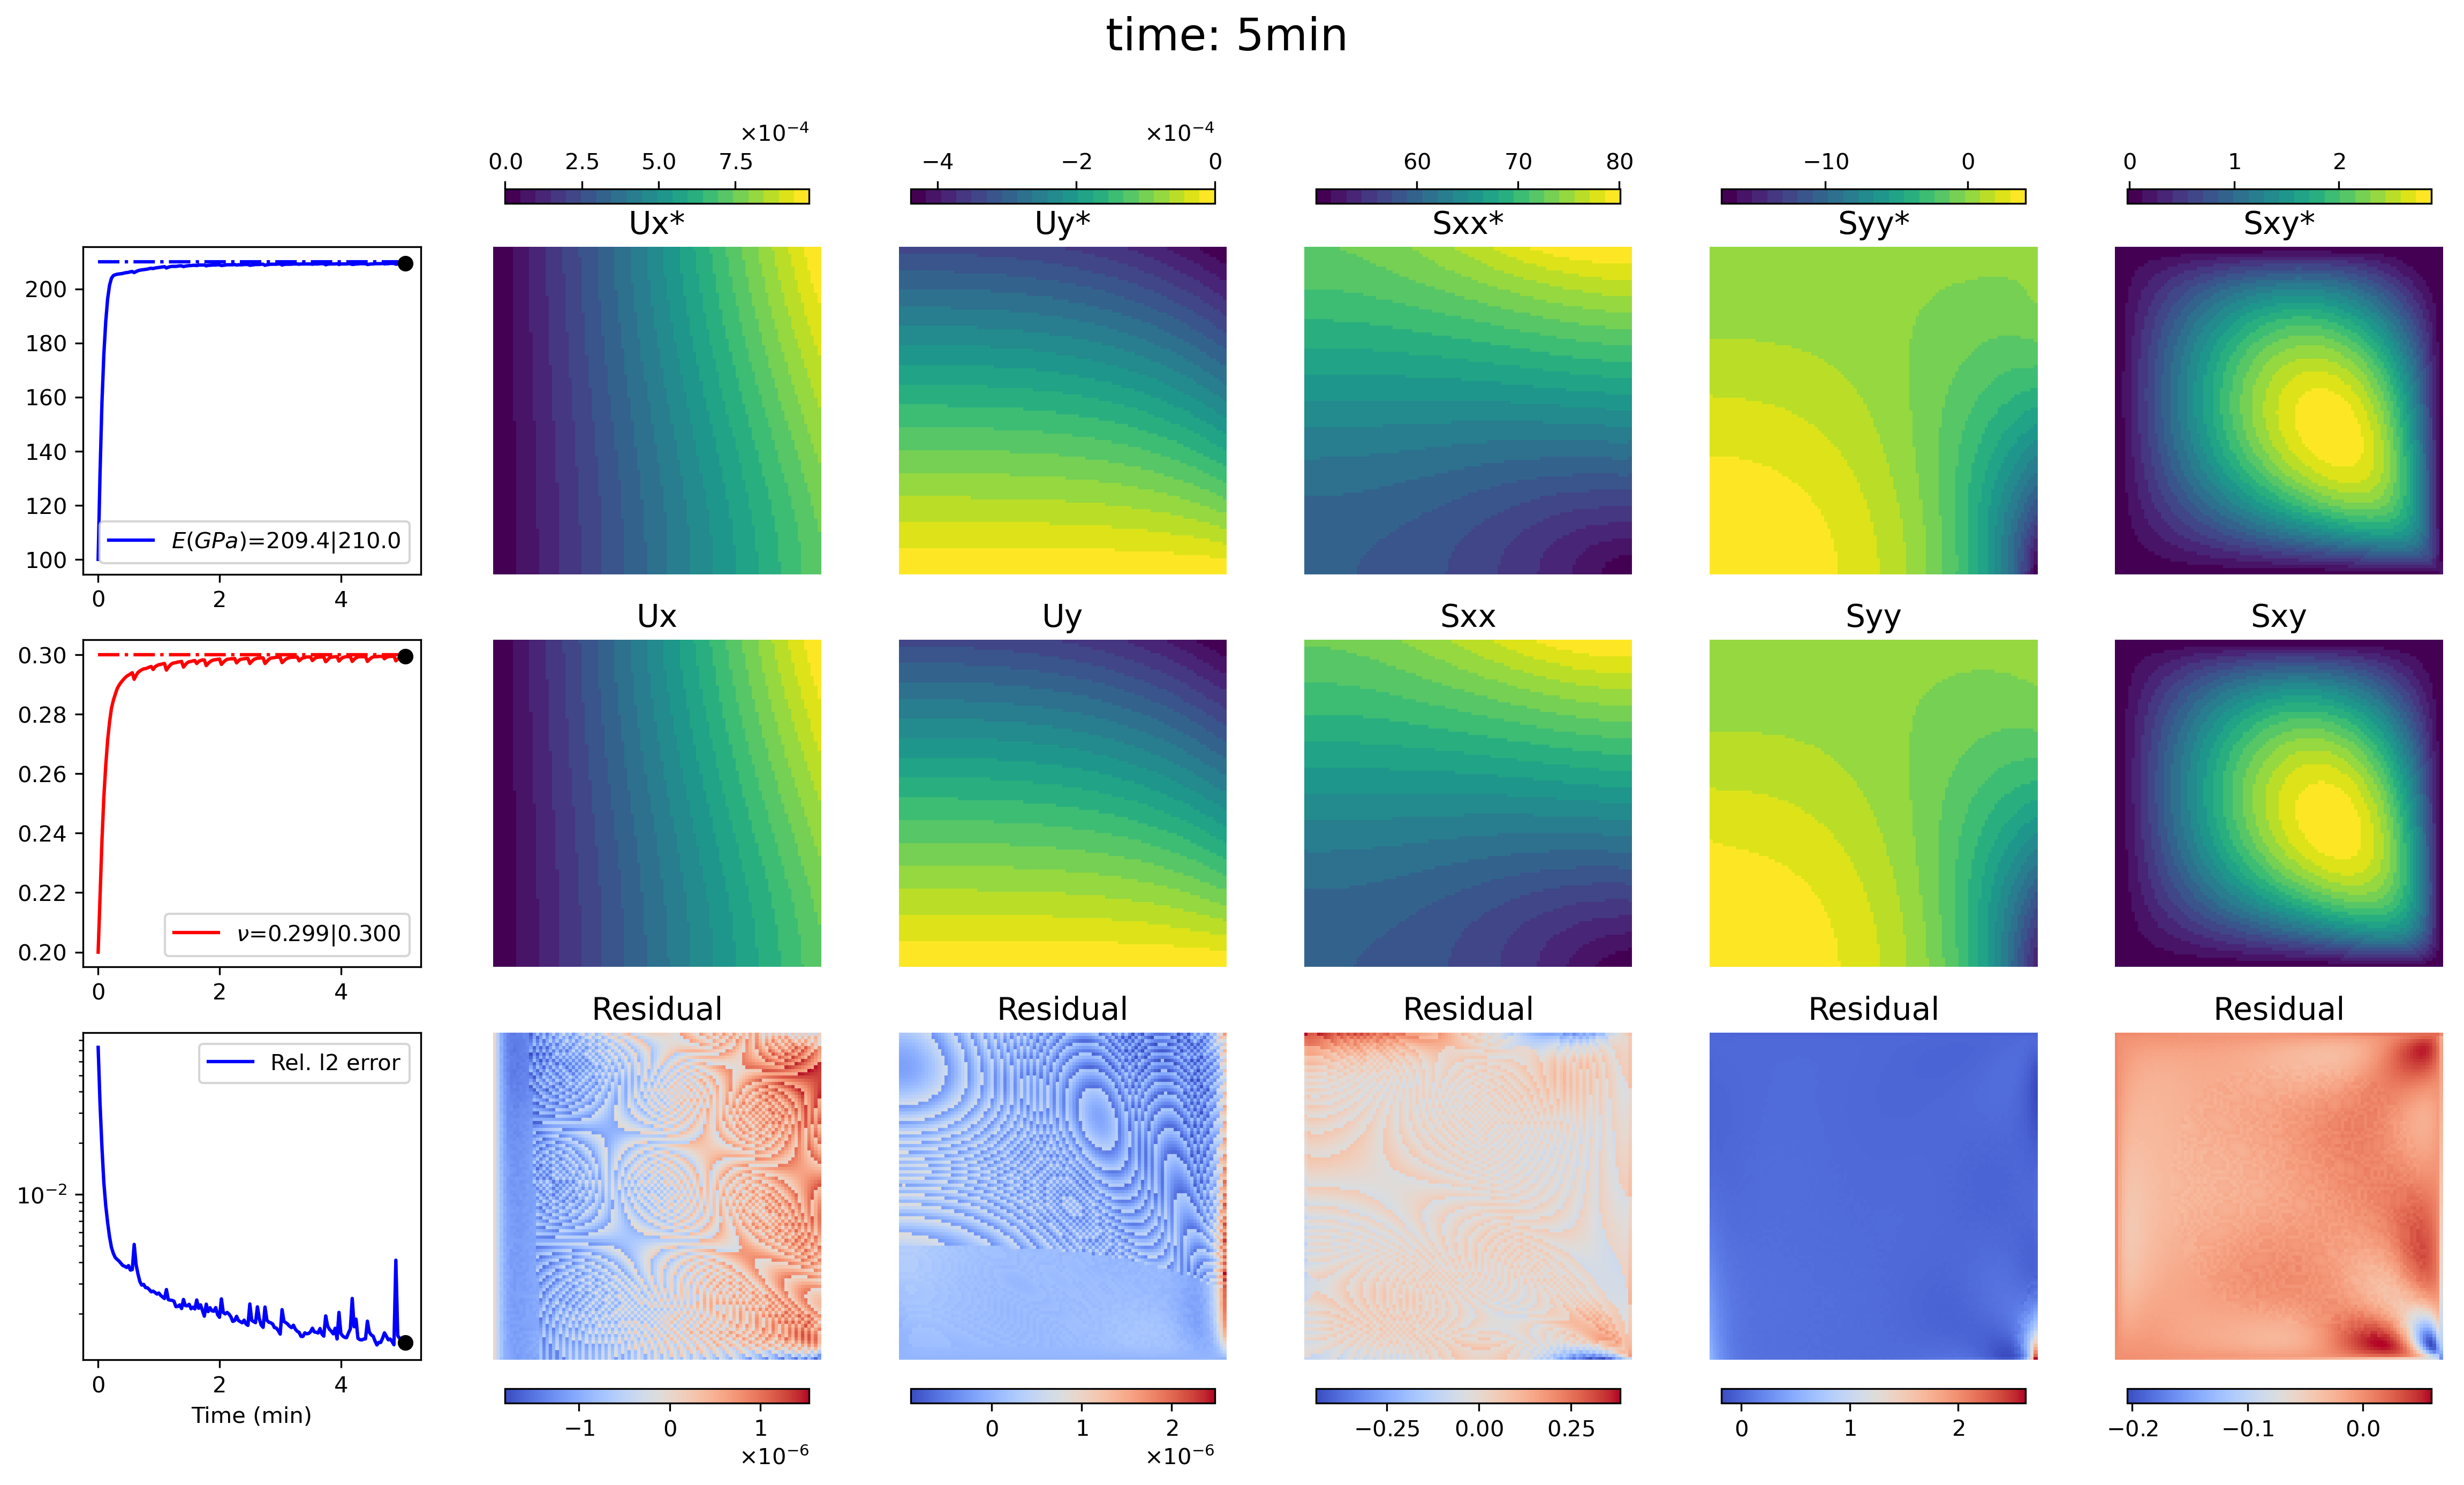

In [62]:
import matplotlib.colors as colors
import os
from scipy.interpolate import RegularGridInterpolator
import matplotlib.ticker as ticker
import matplotlib.transforms as mtransforms


fields_id = [0,1,2,3,4][:] #{0: "Ux", 1: "Uy", 2: "Sxx", 3: "Syy", 4: "Sxy"}
n_fields = len(fields_id)

# Load FEM reference solution
dir_path = r"../fem_data"
data = np.loadtxt(os.path.join(dir_path, "fem_solution_200_points.dat"))

X_val = data[:, :2]
u_val = data[:, 2:4]
stress_val = data[:, 7:10]

solution_val = np.hstack((u_val, stress_val))

n_mesh_points = int(np.sqrt(X_val.shape[0]))

# Interpolate solution
x_grid = np.linspace(0, 3, n_mesh_points)
y_grid = np.linspace(0, 3, n_mesh_points)

interpolators = []
for i in range(solution_val.shape[1]):
    interp = RegularGridInterpolator((x_grid, y_grid), solution_val[:, i].reshape(n_mesh_points, n_mesh_points).T)
    interpolators.append(interp)

func = lambda x: np.array([interp((x[:,0], x[:,1])) for interp in interpolators]).T

cmap = plt.get_cmap('viridis')
num_colors = 20
color_values = [cmap(i) for i in np.linspace(0, 1, num_colors)]
cmap = colors.ListedColormap(color_values)

def pcolor_plot(AX, X, Y, C, title,colormap=cmap,norm=None):
    im = AX.pcolor(X, Y, C, cmap=colormap,shading='auto',norm=norm)
    AX.axis("equal")
    AX.axis("off")
    AX.set_title(title, fontsize=14)
    return im

def plot_field(i, fields, field_id, Xmesh, Ymesh, func, ax, plot_exact=False):
    field = np.array(fields[field_id][i]).reshape(Xmesh.shape)
    field_exact = func(np.hstack((Xmesh.reshape(-1, 1), Ymesh.reshape(-1, 1))))[:,field_id].reshape(Xmesh.shape)
    field_norm = colors.Normalize(vmin=field_exact.min(), vmax=field_exact.max())
    if plot_exact:
        im = pcolor_plot(ax, Xmesh, Ymesh, field_exact, f"{field_names[field_id]}*", norm=field_norm)
    else:
        im = pcolor_plot(ax, Xmesh, Ymesh, field, field_names[field_id], norm=field_norm)

    return im

def plot_field_residual(i, fields, field_id, Xmesh, Ymesh, func, ax, diff_norm, ngrid=100):
    field_exact = func(np.hstack((Xmesh.reshape(-1, 1), Ymesh.reshape(-1, 1))))[:,field_id].reshape(Xmesh.shape)
    field_diff = np.array(fields[field_id][i]).reshape(Xmesh.shape)-field_exact
    im = pcolor_plot(ax, Xmesh, Ymesh, field_diff, "Residual", colormap="coolwarm", norm=diff_norm)
    return im

def set_normdiff(i, fields, fields_id, func, Xmesh, Ymesh, ngrid=100):
    fields_exact = func(np.hstack((Xmesh.reshape(-1, 1), Ymesh.reshape(-1, 1))))

    cmaxs = []  
    cmins = []
    for field_id in fields_id:
        diff = np.array(fields[field_id][i]).reshape(-1,ngrid,ngrid)-fields_exact[:,field_id].reshape(ngrid,ngrid)
        abs_diff = np.abs(diff)
        cmax = abs_diff.max() if diff.max() > 0 else 0
        cmin = -abs_diff.max() if diff.min() < 0 else 0
        cmaxs.append(cmax)
        cmins.append(cmin) 
    normdiff = colors.Normalize(vmin=-1, vmax=1)
    normdiff.vmin = min(cmins)
    normdiff.vmax = max(cmaxs)
    return normdiff

def make_formatter():
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-3, 3))
    return formatter

iter = -1
ngrid = 100
field_id = 0
l_max = 3.0


Xmesh, Ymesh = np.meshgrid(np.linspace(0, l_max, ngrid), np.linspace(0, l_max, ngrid), indexing='ij')
# normdiff = set_normdiff(iter, fields, fields_id, func, Xmesh, Ymesh)

fig, ax = plt.subplots(3,1+n_fields,figsize = (4+n_fields*3,9),dpi = 50+50*n_fields)

line_E, line_nu, scatter_nu, scatter_E, ax_variables = init_variables([ax[0][0], ax[1][0]])
line_E, line_nu, scatter_nu, scatter_E, ax_variables = update_variables(iter, line_E, line_nu, scatter_nu, scatter_E, ax_variables)

lines, scatters = init_metrics(ax[2][0], metrics_idx=metrics_idx)
lines, scatters = update_metrics(iter, lines, scatters, metrics_idx=metrics_idx)
ims_field = []
ims_ref = []
ims_res = []
cbdiffs = []
for i, field_id in enumerate(fields_id):
    ims_ref.append(plot_field(iter, fields, field_id, Xmesh, Ymesh, func, ax[0][i+1],plot_exact=True))
    ims_field.append(plot_field(iter, fields, field_id, Xmesh, Ymesh, func, ax[1][i+1],plot_exact=False))

    # Get the position of the existing axes
    pos = ax[0][i+1].get_position()

    # Define the position of the new axes relative to the existing axes
    cax_pos = mtransforms.Bbox.from_bounds(pos.x0+pos.width*0.05, pos.y1 + 0.03, pos.width*0.9, 0.01)

    # Add the new axes
    cax = fig.add_axes(cax_pos)
    cbfield = fig.colorbar(ims_ref[i], cax=cax, orientation='horizontal', format= make_formatter())
    cbfield.ax.xaxis.set_ticks_position('top')

    ims_res.append(plot_field_residual(iter, fields, field_id, Xmesh, Ymesh, func, ax[2][i+1], None))

    # Get the position of the existing axes
    pos = ax[2][i+1].get_position()

    # Define the position of the new axes relative to the existing axes
    cax_pos = mtransforms.Bbox.from_bounds(pos.x0+pos.width*0.05, pos.y0 - 0.03, pos.width*0.9, 0.01)

    # Add the new axes
    cax = fig.add_axes(cax_pos)
    cbdiffs.append(fig.colorbar(ims_res[i], cax=cax, orientation='horizontal', format= make_formatter()))


fig.suptitle(f"{step_type}: {steps[iter]:.0f}{f"{time_unit}" if step_type == "time" else ""}", fontsize=20, y=1.04)
plt.tight_layout
plt.show()
    

In [49]:
import matplotlib.animation as animation
from IPython.display import HTML
from itertools import chain

def animate(i, ims_field, ims_res, line_E, line_nu, scatter_nu, scatter_E, ax_variables, lines, scatters):

    fig.suptitle(f"{step_type}: {steps[i]:.0f}{f"{time_unit}" if step_type == "time" else ""}", fontsize=16)

    line_E, line_nu, scatter_nu, scatter_E, ax_variables = update_variables(i, line_E, line_nu, scatter_nu, scatter_E, ax_variables)
    lines, scatters = update_metrics(i, lines, scatters)
    

    for im_field, im_res, cbdiff, field_id in zip(ims_field, ims_res, cbdiffs, fields_id):
        field = np.array(fields[field_id][i]).reshape(Xmesh.shape)
        field_exact = func(np.hstack((Xmesh.reshape(-1, 1), Ymesh.reshape(-1, 1))))[:,field_id].reshape(Xmesh.shape)
        field_diff = field-field_exact

        im_field.set_array(field)
        # im_ref.set_array(field_exact)
        im_res.set_array(field_diff)
        
        abs_diff = np.abs(field_diff)
        normdiff = colors.Normalize(vmin=-abs_diff.max(), vmax=abs_diff.max())
        im_res.set_norm(normdiff)
        cbdiff.update_normal(im_res)
        cbdiff.formatter = make_formatter()
        cbdiff.update_ticks()


    return ims_field, ims_res, line_E, line_nu, scatter_nu, scatter_E, ax_variables, lines, scatters

def subsample_steps(steps, sub_factors):
    section_ends = [int(len(steps)*i/len(sub_factors)) for i in range(1, len(sub_factors)+1)]
    frame_steps_lists = []
    for i, step_size in enumerate(sub_factors):
        start = section_ends[i-1] if i > 0 else 0
        end = section_ends[i]
        frame_steps_lists.append(range(start, end, step_size))
    frame_steps = chain.from_iterable(frame_steps_lists)
    return frame_steps


all_steps = list(range(len(steps)))
sub_factors = [2] #list(range(1,4)) + [4]*5 #slower at the beginning
frame_steps = list(subsample_steps(all_steps, sub_factors))

anim = animation.FuncAnimation(fig, animate, fargs=(ims_field, ims_res, line_E, line_nu, scatter_nu, scatter_E, ax_variables, lines, scatters), frames=frame_steps, interval=100, repeat=False)

fps = 10
print("Video duration: ", len(frame_steps)/fps, "s")
# HTML(anim.to_jshtml())

Video duration:  8.9 s


In [50]:
# video_name = f"./videos/{"-".join([field_names[field_id] for field_id in fields_id])}_lambda-{lmbd_start}_mu-{mu_start}_nDIC-{nDIC}_{net_type}_{iteration}iter_{step_type}"
video_name = f"{"-".join([field_names[field_id] for field_id in fields_id])}_{step_type}"
video_path = f"{run_folder}{video_name}"
anim.save(f"{video_path}.mp4", writer='ffmpeg', fps=10)
# anim.save(f"{video_name}.gif", writer='imagemagick', fps=10)
print(f"Video saved at {video_path}.mp4")

Video saved at ../results_inverse/spinn_E-100000.0_nu-0.2_nDIC-100_noise-0_5min-2/Ux-Uy-Sxx-Syy-Sxy_time.mp4
